In [1]:
%%capture
import pandas as pd
%pip install matplotlib scikit-learn numpy openai

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np


In [4]:
df= pd.read_csv("survey.csv")

df = df.dropna()

In [5]:
#define number of embedding
job_embedding_dim = 24
reason_embedding_dim = 48

In [7]:
%%capture
pip install sentence-transformers


In [8]:

from sentence_transformers import SentenceTransformer

# Load a free model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings (Dimensions are fixed at 384 for this free model)
job_response = model.encode(df['job_title'].astype(str).tolist())
reason_embeddings = model.encode(df['join_reason'].astype(str).tolist())

print("Embeddings generated for free locally!")

Embeddings generated for free locally!


In [9]:
df['job_response_embedding']= list(job_response)
df['reason_response_embedding']= list(reason_embeddings)

combined_matrix = np.hstack((job_response,reason_embeddings))
kmeans = KMeans(n_clusters = 5, random_state = 42)
df['pocket_id'] = kmeans.fit_predict(combined_matrix)
df.head()

,job_title,join_reason,job_response_embedding,reason_response_embedding,pocket_id
0,Founder,"How to fine tune LLM effectively, and what LLM...","[-0.047343895, 0.034723222, -0.022134982, 0.02...","[0.052545823, -0.04648134, 0.022773711, -0.062...",1
1,Financial Management & Compliance Advisor,Gain knowledge and skills to be able to develo...,"[-0.011546542, -0.020555275, -0.07790024, 0.08...","[-0.01709779, -0.0040206807, -0.013721654, 0.0...",3
2,Founder in the making,Build an AI product,"[-0.055006728, 0.0035471085, -0.026791397, 0.0...","[-0.05745628, -0.063700005, 0.010663196, -0.07...",1
3,Staff Scientist,Better understanding and skill set in AI to ma...,"[-0.07639789, 0.03228998, 0.017382652, 0.04721...","[-0.03842058, -0.021444675, 0.017009234, 0.066...",3
4,Data scientist,Getting skills (for my resume),"[-0.035740145, -0.005845778, -0.012968947, 0.0...","[-0.047130946, -0.022206033, -0.0045244102, 0....",2


In [11]:
#visualize


In [12]:
%%capture
pip install seaborn

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np

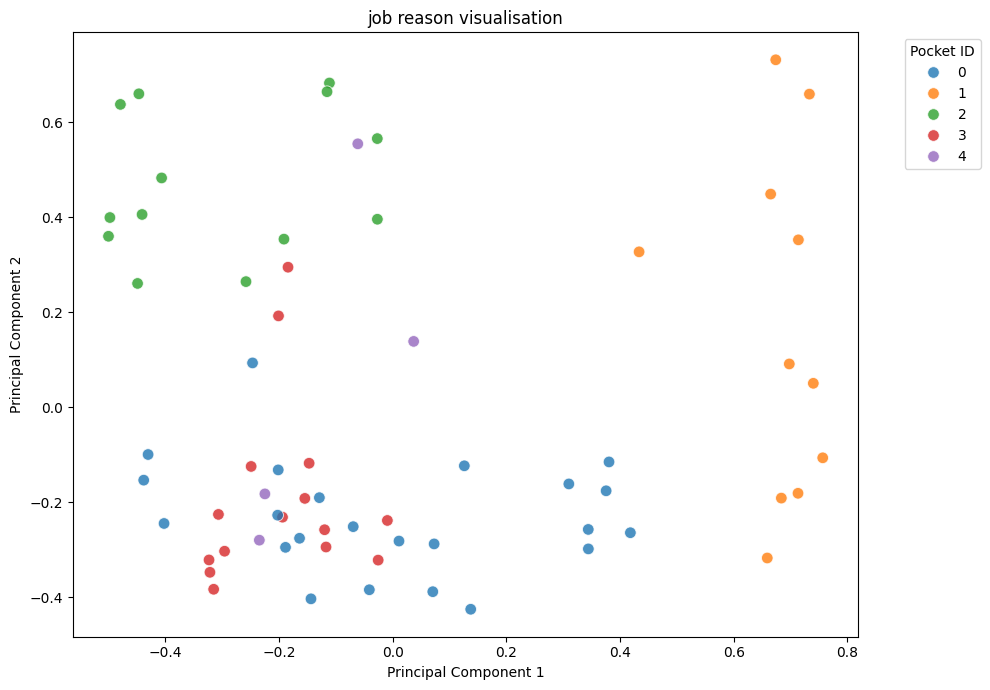

In [15]:
matrix = np.hstack((np.stack(df['job_response_embedding'].values),
                    np.stack(df['reason_response_embedding'].values)
                   ))

pca = PCA(n_components=2)
vis_dims = pca.fit_transform(matrix)

df['x'] = vis_dims[:, 0]
df['y'] = vis_dims[:, 1]

plt.figure(figsize = (10,7))
sns.scatterplot( 
    data=df,
    x='x',
    y='y',
    hue ='pocket_id',
    palette='tab10',
    s=70,
    alpha=0.8
)

plt.title('job reason visualisation')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Pocket ID', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import pairwise_distances_argmin_min

n_pockets = 5
top_n_words = 4

matrix = np.hstack((
    np.stack(df['job_response_embedding'].values),
    np.stack(df['reason_response_embedding'].values)
))

closest_indices, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, matrix)

# to get top word
def get_top_keyword(text_series):
    #using countvectorizer to ignore the, and
    vec = CountVectorizer(stop_words ='english', ngram_range=(1,2))
    try:
        bow = vec.fit_transform(text_series)
        sum_words = bow.sum(axis=0)
        word_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        word_freq= sorted(word_freq, key= lambda x: x[1], reverse =True)
        return [w[0] for w in word_freq[:top_n_words]]
    except ValueError:
        return ["Not enough data"]
    
print(f"{'POCKET':<8} | {'THEME (Top Keywords)':<35} | {'TYPICAL EXAMPLE (The Archetype)'}")
print("-" * 100)

for pocket_id in range(n_pockets):
    subset = df[df['pocket_id']== pocket_id]

    keywords = get_top_keyword(subset['join_reason'])
    keyword_str = ", ".join(keywords)

    rep_index = closest_indices[pocket_id]
    rep_job = df.iloc[rep_index]['job_title']
    rep_reason = df.iloc[rep_index]['join_reason']

    print(f"#{pocket_id:<7} | {keyword_str:<35} | {rep_job}: \"{str(rep_reason)[:50]}...\"")

POCKET   | THEME (Top Keywords)                | TYPICAL EXAMPLE (The Archetype)
----------------------------------------------------------------------------------------------------
#0       | ai, build, understanding, like      | Technology Analyst: "Understand and create projects using AI where most..."
#1       | ai, like, build, llm                | Founder: "More insight on creating production-ready AI appli..."
#2       | use, learn, data, llm               | Data Scientist: "Gain hands-on experience interfacing with LLMs, ne..."
#3       | ai, knowledge, product, use         | Senior Program Manager: "Be more knowledgeable with AI..."
#4       | ai, experience, environment, learning | Senior Software Engineer: "Hands on experience in learning AI that will help ..."
